# Fractals, Chaos, Complex Numbers

In [71]:
# Settings and imports.
%matplotlib inline
from collections import Counter, OrderedDict, defaultdict
from functools import partial
from itertools import count, combinations
from math import sqrt, pi, sin, cos, atan, radians, degrees
import os
from random import random, choice
from time import time
import json
from IPython.display import display, Video
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageColor
import seaborn as sns

from drawing import VectorImage, Turtle, show_image

TODO (opt):
- choose colors based on the last/highest number in the series or other criteria (possible different criteria for different RGB parts)
- try using Matplotlib directly without Image library (factor out as BitmapImage with methods: show, save, and put|getpixel via brackets)

-----

# A) Newton Fractal

In [2]:
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
#COLORS = [(200, 0, 0), (0, 200, 0), (0, 0, 200)]

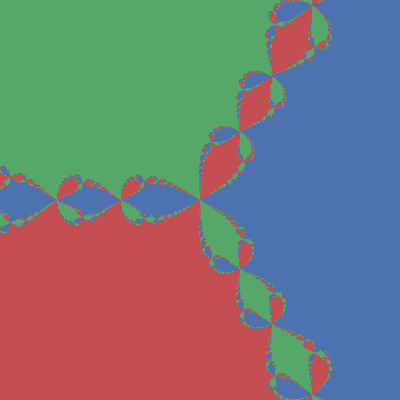

In [117]:
def to_int_rgb(colors):
    return [tuple(int(255*band) for band in color) for color in colors]

def newton_method(start, n_iter=20):
    point = start
    for i in range(n_iter):
        if point == 0:
            return point
        point = point - (point**3 - 1)/(3 * (point**2))
    return point    

def newton_fractal(xmin=-2, xmax=2, ymin=-2, ymax=2,
                   width=400):
    colors = to_int_rgb(sns.color_palette())
    height = int(width * (ymax-ymin)/(xmax-xmin))
    im = Image.new('RGB', (width, height), color='white') 
    solutions = [1, -0.5 + 1j*sqrt(3)/2, -0.5 - 1j*sqrt(3)/2]
    for ix in range(width):
        for iy in range(height):
            x = xmin + (xmax - xmin) * ix / (width-1)
            y = ymin + (ymax - ymin) * (height-iy-1) / (height-1)
            z = newton_method(x + y*1j)
            i_sol = min(range(3), key=lambda i: abs(z - solutions[i]))
            color = colors[i_sol]
            im.putpixel((ix, iy), color)
    return im  
    
newton_fractal()

-----

# B) Mandelbrot Fractal

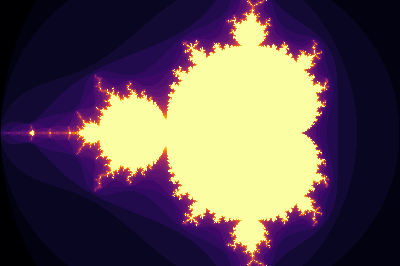

In [105]:
def mandelbrot_fractal(xmin=-2, xmax=1, ymin=-1, ymax=1,
                       n_steps=30, width=400, n_colors=100):
    """Return an image with a zoomed view of colored Mandelbrot set.
    """
    height = int(width * (ymax-ymin)/(xmax-xmin))
    im = Image.new('RGB', (width, height), color='white')
    colors = to_int_rgb(plt.get_cmap('inferno', n_colors).colors)
    # Alternative palettes:
    #colors = to_int_rgb(sns.cubehelix_palette(n_colors))
    #colors = to_int_rgb(plt.get_cmap('viridis', n_colors).colors)
    for ix in range(width):
        for iy in range(height):
            x = xmin + (xmax - xmin) * ix / (width-1)
            y = ymin + (ymax - ymin) * (height-iy-1) / (height-1)
            c = complex(x, y)
            z, steps = mandelbrot_steps(c, n_steps=n_steps)
            # Grayscale coloring:
            #intensity = 255 - int(255 * steps/n_steps)
            #color = (intensity, intensity, intensity)
            # Using colormap:
            color = colors[int((n_colors-1) * steps/n_steps)]
            im.putpixel((ix, iy), color)
    return im

def mandelbrot_steps(c, z=complex(0, 0), threshold=2, n_steps=30):
    """Return number of mandelbrot series and number of steps
       needed to exceed the threshold (max n_steps).
    """
    for i_step in range(n_steps):
        z = z**2 + c
        if abs(z) >= threshold:
            return z, i_step
    return z, n_steps

def mandelbrot_zoom(x, y, eps):
    return mandelbrot_fractal(
        xmin=x-eps, xmax=x+eps, ymin=y-eps, ymax=y+eps)

mandelbrot_fractal()

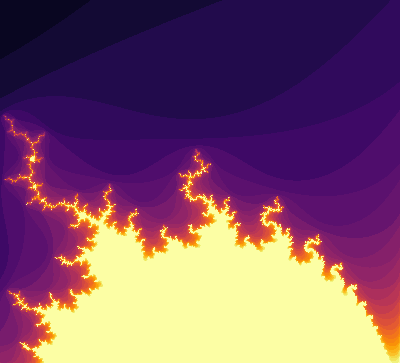

In [106]:
mandelbrot_fractal(xmin=-1.3, xmax=-0.75, ymin=0.1, ymax=0.6)

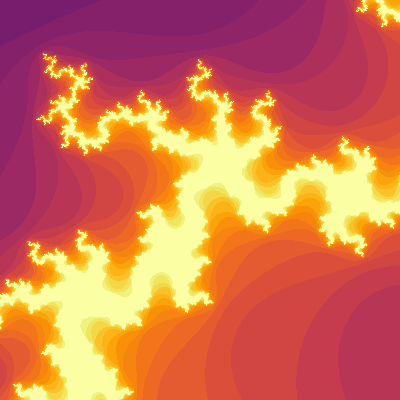

In [135]:
mandelbrot_fractal(xmin=-0.94, xmax=-0.92, ymin=0.3, ymax=0.32)

In [78]:
# Demo of interactive widgets (works only inside jupyter notebook).

# def show_mandelbrot(xrange, yrange):
#     im = mandelbrot_fractal(
#         xmin=xrange[0], xmax=xrange[1],
#         ymin=yrange[0], ymax=yrange[1])
#     show_image(im, flipy=True)

# xrange = widgets.FloatRangeSlider(
#     value=[-0.94, -0.92], min=-2, max=1, step=0.01,
#     description='x', continuous_update=False)
# yrange = widgets.FloatRangeSlider(
#     value=[0.3, 0.32], min=-1, max=1, step=0.01,
#     description='y', continuous_update=False)

# widgets.interact(show_mandelbrot, xrange=xrange, yrange=yrange)

In [192]:
def save_mandelbrot_images(
        x_end, y_end, eps, n_img,
        xmin_start=-2, xmax_start=1, ymin_start=-1, ymax_start=1):
    os.makedirs('img', exist_ok=True)
    digits = len(str(n_img))
    path_tplt = 'img/mandelbrot-{{i:0{d}d}}.png'.format(d=digits)
    for i in range(1, n_img+1):
        # Shrinking is nonlinear to avoid too slow beginning.
        t = eps + (1-eps) * (((n_img-i)/(n_img-1)) ** 2)
        # Linear shrinking: t = 1 - (1-eps) * (i-1)/(n_img-1)
        xmin = xmin_start * t + x_end * (1-t)
        xmax = xmax_start * t + x_end * (1-t)
        ymin = ymin_start * t + y_end * (1-t)
        ymax = ymax_start * t + y_end * (1-t)
        im = mandelbrot_fractal(xmin, xmax, ymin, ymax)
        path = path_tplt.format(i=i)
        im.save(path)
        
def create_mandelbrot_video(x_end, y_end, eps, n_img):
    save_mandelbrot_images(
        x_end=x_end, y_end=y_end, eps=eps, n_img=n_img)
    # Create a video from images:
    d = len(str(n_img))  # digits
    r = 10  # framerate
    ! cd img; \
      ffmpeg -r {r} -i mandelbrot-%0{d}d.png \
        -y -hide_banner -loglevel warning \
        mandelbrot.mp4
        
#create_mandelbrot_video(x_end=-0.93, y_end=0.31, eps=0.01, n_img=100)
create_mandelbrot_video(x_end=-0.927, y_end=0.309, eps=0.0005, n_img=100)

In [193]:
Video('img/mandelbrot.mp4')

-----

# C) Julia 

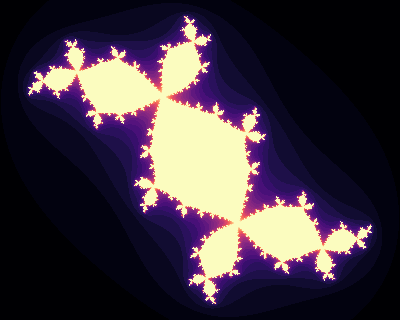

In [116]:
def julia_fractal(c=-0.13+0.75j,
                  xmin=-1.5, xmax=1.5, ymin=-1.2, ymax=1.2,
                  n_steps=30, width=400, n_colors=100):
    height = int(width * (ymax-ymin)/(xmax-xmin))
    im = Image.new('RGB', (width, height), color='white')
    colors = to_int_rgb(plt.get_cmap('magma', n_colors).colors)
    for ix in range(width):
        for iy in range(height):
            x = xmin + (xmax - xmin) * ix / (width-1)
            y = ymin + (ymax - ymin) * (height-iy-1) / (height-1)
            z, steps = mandelbrot_steps(
                c=c, z=complex(x, y), n_steps=n_steps)
            # Binary coloring:
            # color = BLACK if abs(z) < 2 else WHITE
            # Grayscale coloring:
            # intensity = 255 - int(255 * steps/n_steps)
            # color = (intensity, intensity, intensity)
            # Colormap:
            color = colors[int((n_colors-1) * steps/n_steps)]
            im.putpixel((ix, iy), color)
    return im

julia_fractal()

In [100]:
def save_julia_images(c_start, c_end, n_img):
    os.makedirs('img', exist_ok=True)
    digits = len(str(n_img))
    path_tplt = 'img/julia-{{i:0{digits}d}}.png'.format(digits=digits)
    for i in range(1, n_img+1):
        t = 1 - (i-1)/(n_img-1) if n_img > 1 else 1
        c = c_start * t + c_end * (1-t)
        im = julia_fractal(c)
        path = path_tplt.format(i=i)
        im.save(path)
        
def create_julia_video(c_start, c_end, n_img):
    save_julia_images(c_start, c_end, n_img=n_img)
    # Create a video from images:
    d = len(str(n_img))  # digits
    r = 10  # framerate
    ! cd img; \
      ffmpeg -r {r} -i julia-%0{d}d.png \
        -y -hide_banner -loglevel warning \
        julia.mp4
        
create_julia_video(c_start=-0.3+0.4j, c_end=0.8+1.7j, n_img=100)

In [109]:
Video('img/julia.mp4')